Analytic posterior = Beta(3, 4)


c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\threadpoolctl.py:1226: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [p]


c:\Users\flare\miniforge3\envs\pymc_env\Lib\site-packages\rich\live.py:260: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 2 chains for 1_500 tune and 3_000 draw iterations (3_000 + 6_000 draws total) took 32 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


MCMC mean     = 0.421939
Analytic mean = 0.428571
MCMC 95% HDI  = [0.097851, 0.750967]
Analytic 95% CI (Beta quantile) = [0.118117, 0.777222]


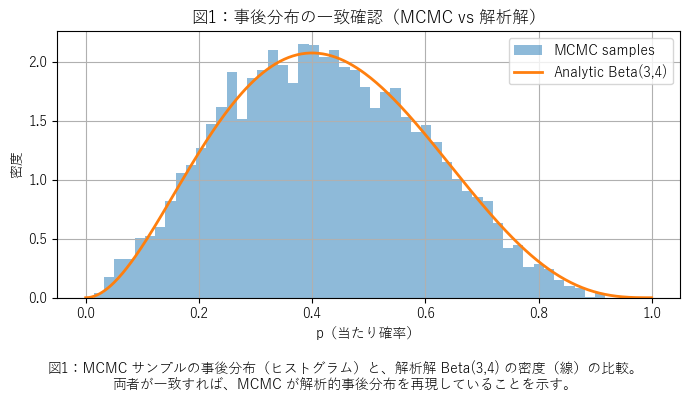

    mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
p  0.422  0.175   0.099    0.731      0.004    0.002    1753.0    1851.0   

   r_hat  
p    1.0  


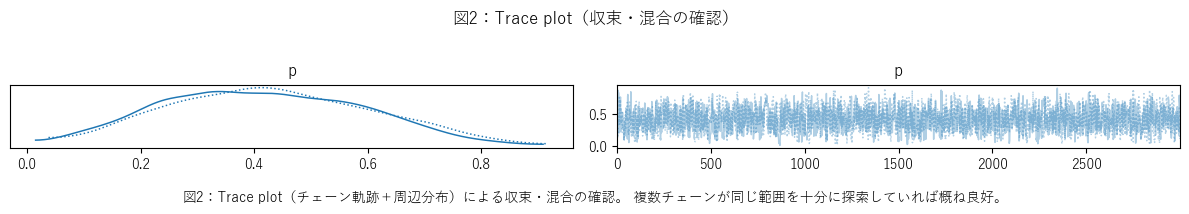

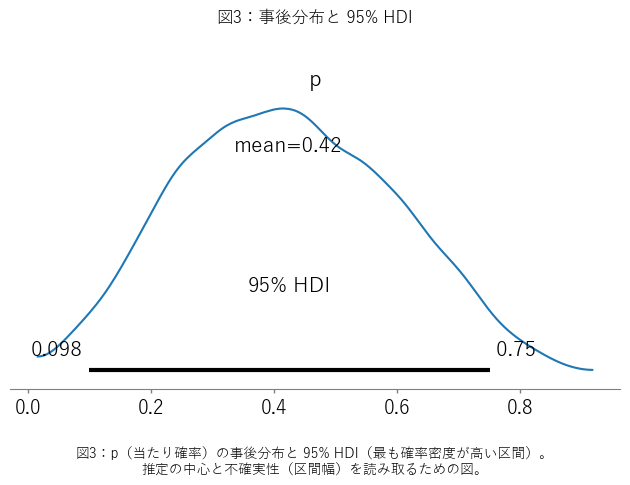

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import pymc as pm
import arviz as az
from scipy.stats import beta as sp_beta

# -----------------------------
# 文字化け対策：日本語フォント設定（Windows想定で候補を順に試す）
# -----------------------------
def set_japanese_font():
    candidates = [
        "IPAexGothic", "IPAGothic",
        "Yu Gothic", "YuGothic",
        "Meiryo", "Meiryo UI",
        "MS Gothic", "MS PGothic",
        "Noto Sans CJK JP", "Noto Sans JP",
    ]
    # 利用可能フォントの中から選ぶ
    available = set(f.name for f in plt.matplotlib.font_manager.fontManager.ttflist)
    for name in candidates:
        if name in available:
            plt.rcParams["font.family"] = name
            break
    # マイナス記号の文字化け対策
    plt.rcParams["axes.unicode_minus"] = False

set_japanese_font()

# -----------------------------
# キャプション（ハードコーディング）
# -----------------------------
CAPTION_FIG1 = (
    "図1：MCMC サンプルの事後分布（ヒストグラム）と、解析解 Beta(3,4) の密度（線）の比較。"
    " 両者が一致すれば、MCMC が解析的事後分布を再現していることを示す。"
)
CAPTION_FIG2 = (
    "図2：Trace plot（チェーン軌跡＋周辺分布）による収束・混合の確認。"
    " 複数チェーンが同じ範囲を十分に探索していれば概ね良好。"
)
CAPTION_FIG3 = (
    "図3：p（当たり確率）の事後分布と 95% HDI（最も確率密度が高い区間）。"
    " 推定の中心と不確実性（区間幅）を読み取るための図。"
)

def add_caption(fig, text, fontsize=10, y=0.01):
    fig.text(0.5, y, text, ha="center", va="bottom", fontsize=fontsize, wrap=True)

def get_fig_from_axes(ax_like):
    """
    ArviZの戻り値は、Axes単体 / ndarray of Axes / list of Axes など揺れることがある。
    どれでも fig を取り出せるようにする。
    """
    # Axes単体
    if hasattr(ax_like, "figure"):
        return ax_like.figure
    # ndarray / list 等
    arr = np.asarray(ax_like, dtype=object)
    first = arr.flat[0]
    return first.figure

# -----------------------------
# 観測データ（当たり=1, はずれ=0）
# -----------------------------
data = np.array([1, 0, 0, 1, 0], dtype=int)
k = int(data.sum())
n = int(len(data))

# 解析解（事前 Beta(1,1)）
alpha_prior, beta_prior = 1, 1
alpha_post = alpha_prior + k
beta_post  = beta_prior  + (n - k)

print(f"Analytic posterior = Beta({alpha_post}, {beta_post})")

with pm.Model() as model:
    p = pm.Beta("p", alpha=alpha_prior, beta=beta_prior)
    y = pm.Bernoulli("y", p=p, observed=data)

    trace = pm.sample(
        draws=3000,
        tune=1500,
        chains=2,
        target_accept=0.95,
        random_seed=42,
        progressbar=True
    )

# --- 数値比較（平均・HDI） ---
p_samples = trace.posterior["p"].values.reshape(-1)

mcmc_mean = float(p_samples.mean())
analytic_mean = alpha_post / (alpha_post + beta_post)

hdi = az.hdi(p_samples, hdi_prob=0.95)
print(f"MCMC mean     = {mcmc_mean:.6f}")
print(f"Analytic mean = {analytic_mean:.6f}")
print(f"MCMC 95% HDI  = [{float(hdi[0]):.6f}, {float(hdi[1]):.6f}]")
print(f"Analytic 95% CI (Beta quantile) = "
      f"[{sp_beta.ppf(0.025, alpha_post, beta_post):.6f}, {sp_beta.ppf(0.975, alpha_post, beta_post):.6f}]")

# --- 図1：MCMCヒストグラム vs 解析Beta密度 ---
x = np.linspace(0, 1, 400)
pdf = sp_beta.pdf(x, alpha_post, beta_post)

fig1 = plt.figure(figsize=(7,4))
plt.hist(p_samples, bins=50, density=True, alpha=0.5, label="MCMC samples")
plt.plot(x, pdf, linewidth=2, label=f"Analytic Beta({alpha_post},{beta_post})")
plt.xlabel("p（当たり確率）")
plt.ylabel("密度")
plt.title("図1：事後分布の一致確認（MCMC vs 解析解）")
plt.grid(True)
plt.legend()

fig1.tight_layout(rect=[0, 0.10, 1, 1])
add_caption(fig1, CAPTION_FIG1, fontsize=10, y=0.01)
plt.show()

# --- 図2：Trace plot（収束確認） ---
print(az.summary(trace, var_names=["p"]))

ax2 = az.plot_trace(trace, var_names=["p"])
fig2 = get_fig_from_axes(ax2)
fig2.suptitle("図2：Trace plot（収束・混合の確認）", y=0.98)

fig2.tight_layout(rect=[0, 0.10, 1, 0.95])
add_caption(fig2, CAPTION_FIG2, fontsize=10, y=0.01)
plt.show()

# --- 図3：Posterior（HDI付き事後分布） ---
ax3 = az.plot_posterior(trace, var_names=["p"], hdi_prob=0.95)
fig3 = get_fig_from_axes(ax3)
fig3.suptitle("図3：事後分布と 95% HDI", y=0.98)

fig3.tight_layout(rect=[0, 0.10, 1, 0.95])
add_caption(fig3, CAPTION_FIG3, fontsize=10, y=0.01)
plt.show()
